Copyright 2025 Joe Worsham

In [1]:
# obligatory reload content dynamically
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow_dynamics as tfd

2025-07-08 06:30:48.415873: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-08 06:30:48.423651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751977848.432642   10637 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751977848.435335   10637 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751977848.442037   10637 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
import itertools
import math
import numpy as np
import tensorflow as tf

In [4]:
from collections import namedtuple
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from tqdm import tqdm

In [5]:
tf.keras.backend.set_floatx('float64')

# Nested n-Spheres Problem

The next n-Spheres problem is an aribitrary function that cannot be represented by a NODE. It is defined below.

In [6]:
r1 = 1.
r2 = 2.
r3 = 3.

gx_min1_polar = tf.random.uniform([1000, 2], minval=[0., 0.], maxval=[r1, 2*math.pi], dtype=tf.float64)
gx_1_polar = tf.random.uniform([1000, 2], minval=[r2, 0.], maxval=[r3, 2*math.pi], dtype=tf.float64)

gx_min1 = tf.stack([gx_min1_polar[..., 0] * tf.math.cos(gx_min1_polar[..., 1]),
                    gx_min1_polar[..., 0] * tf.math.sin(gx_min1_polar[..., 1])],
                   axis=-1)
gx_1 = tf.stack([gx_1_polar[..., 0] * tf.math.cos(gx_1_polar[..., 1]),
                 gx_1_polar[..., 0] * tf.math.sin(gx_1_polar[..., 1])],
                axis=-1)

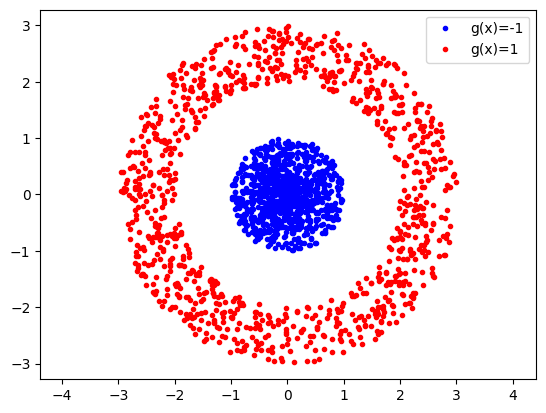

In [7]:
plt.plot(gx_min1[..., 0], gx_min1[..., 1], 'b.', label="g(x)=-1")
plt.plot(gx_1[..., 0], gx_1[..., 1], 'r.', label="g(x)=1")
plt.axis('equal')
plt.legend()
plt.show()

In [8]:
x = tf.concat([gx_min1, gx_1], axis=0)
y = tf.cast(tf.concat([[-1,]*1000, [1,]*1000], axis=0), dtype=tf.float64)

# NODE Experiments

In [9]:
class NodeClassifier(tf.keras.Model):
    def __init__(self, node):
        super().__init__()
        self._node = node
        self._linear_transform = tfd.models.layers.LinearTransform(1)
        
    def call(self, x):
        x = self._node(x)
        return self._linear_transform(x)

In [10]:
def run_experiment(dx_dt, encoder, decoder, method, options, use_adjoint, adjoint_options, epochs=200, lr=1e-3):
    # build the NODE to test
    t_0 = tf.zeros([1,], dtype=tf.float64)
    t_f = tf.ones([1,], dtype=tf.float64)
    time_range = tf.linspace(t_0, t_f, 65)
    time_range = tf.transpose(time_range, [1, 0])
    node = tfd.models.node.BaseNODE(dx_dt=dx_dt, encoder=encoder, decoder=decoder,
                                    t_eval=time_range,
                                    method=method, options=options, use_adjoint=use_adjoint,
                                    adjoint_options=adjoint_options)
    node = NodeClassifier(node)
    
    # touch to initialize weights
    y_hat = node(x)
    
    # train for specified epochs
    losses = []
    mse = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    start_time = timer()
    for i in tqdm(range(epochs)):
        with tf.GradientTape() as tape:
            y_hat = node(x)
            y_f_hat = y_hat[:, -1, :]
            loss = mse(y, y_f_hat)
        grads = tape.gradient(loss, node.trainable_variables)
        optimizer.apply_gradients(zip(grads, node.trainable_variables))
        losses.append(loss)
    
    end_time = timer()
    duration_s = end_time - start_time
        
    return node, losses, duration_s

## Define the Experiment Space

In [11]:
Method = namedtuple("Method", ["name", "options", "adjoint_options"])

rk4 = "rk4"
dopri5 = "dopri5"

rk4_options = dict(h=tf.cast(1/32., dtype=tf.float64))
rk4_adjoint_options = rk4_options

dp5_options = dict(rtol=1e-3, atol=1e-3)
dp5_adjoint_options = dict(rtol=1e-3, atol=1e-3)

methods = [Method(rk4, rk4_options, rk4_adjoint_options),
           Method(dopri5, dp5_options, dp5_adjoint_options)]

In [12]:
adjoints = [True, False]

In [13]:
Encoder = namedtuple("Encoder", ["name", "encoder", "decoder"])

node_encoders = [
    Encoder("none", None, None)
]

anode_encoders = [
    Encoder("linear_augment", tfd.models.layers.LinearAugmenter(1), tfd.models.layers.Truncate(2)),
    Encoder("linear_transform", tfd.models.layers.LinearTransform(3), tfd.models.layers.LinearTransform(2)),
    Encoder("mlp_augment", tfd.models.layers.MLPAugmenter(1), tfd.models.layers.Truncate(2)),
    Encoder("mlp_transform", tfd.models.layers.MLPTransform(3), tfd.models.layers.MLPTransform(2)),
    Encoder("zero_augment", tfd.models.layers.ZeroAugmenter(2, 1), tfd.models.layers.Truncate(2))
]

sonode_encoders = [
    Encoder("linear_augment", tfd.models.layers.LinearAugmenter(2), tfd.models.layers.Truncate(2)),
    Encoder("linear_transform", tfd.models.layers.LinearTransform(4), tfd.models.layers.LinearTransform(2)),
    Encoder("mlp_augment", tfd.models.layers.MLPAugmenter(2), tfd.models.layers.Truncate(2)),
    Encoder("mlp_transform", tfd.models.layers.MLPTransform(4), tfd.models.layers.MLPTransform(2)),
    Encoder("zero_augment", tfd.models.layers.ZeroAugmenter(2, 2), tfd.models.layers.Truncate(2))
]

In [14]:
Experiment = namedtuple("Experiment", ["name", "method", "options", "use_adjoint",
                                       "adjoint_options", "dx_dt", "encoder", "decoder"])

In [15]:
experiments = []

# build NODE experiments
for method, adjoint, encoder in itertools.product(methods, adjoints, node_encoders):
    node = tfd.models.layers.AutonomousDxDtMLP(2)
    exp_name = f"node_{method.name}_adjoint_{adjoint}_{encoder.name}"
    exp = Experiment(exp_name, method.name, method.options, adjoint, method.adjoint_options,
                     node, encoder.encoder, encoder.decoder)
    experiments.append(exp)
    
# build ANODE experiments
for method, adjoint, encoder in itertools.product(methods, adjoints, anode_encoders):
    anode = tfd.models.layers.AutonomousDxDtMLP(3)
    exp_name = f"anode_{method.name}_adjoint_{adjoint}_{encoder.name}"
    exp = Experiment(exp_name, method.name, method.options, adjoint, method.adjoint_options,
                     anode, encoder.encoder, encoder.decoder)
    experiments.append(exp)
    
# build SONODE experiments
for method, adjoint, encoder in itertools.product(methods, adjoints, sonode_encoders):
    sonode = tfd.models.layers.Autonomous2ndOrderDxDtMLP(2)
    exp_name = f"sonode_{method.name}_adjoint_{adjoint}_{encoder.name}"
    exp = Experiment(exp_name, method.name, method.options, adjoint, method.adjoint_options,
                     sonode, encoder.encoder, encoder.decoder)
    experiments.append(exp)

In [16]:
len(experiments)

44

## Run All Experiments

In [17]:
Result = namedtuple("Result", ["name", "losses", "duration_s"])

In [18]:
results = []
for exp in experiments:
    print(exp.name)
    _, losses, duration_s = run_experiment(exp.dx_dt, exp.encoder, exp.decoder, exp.method,
                                           exp.options, exp.use_adjoint, exp.adjoint_options)
    results.append(Result(exp.name, losses, duration_s))

node_rk4_adjoint_True_none


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier/base_node/odeint_solver/autonomous_dx_dt_mlp/dense_24/kernel', 'node_classifier/base_node/odeint_solver/autonomous_dx_dt_mlp/dense_24/bias', 'node_classifier/base_node/odeint_solver/autonomous_dx_dt_mlp/dense_25/kernel', 'node_classifier/base_node/odeint_solver/autonomous_dx_dt_mlp/dense_25/bias', 'node_classifier/base_node/odeint_solver/autonomous_dx_dt_mlp/dense_26/kernel', 'node_classifier/base_node/odeint_solver/autonomous_dx_dt_mlp/dense_26/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [00:55<00:00,  3.61it/s]


node_rk4_adjoint_False_none


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_1/base_node_1/odeint_solver_1/autonomous_dx_dt_mlp_1/dense_27/kernel', 'node_classifier_1/base_node_1/odeint_solver_1/autonomous_dx_dt_mlp_1/dense_27/bias', 'node_classifier_1/base_node_1/odeint_solver_1/autonomous_dx_dt_mlp_1/dense_28/kernel', 'node_classifier_1/base_node_1/odeint_solver_1/autonomous_dx_dt_mlp_1/dense_28/bias', 'node_classifier_1/base_node_1/odeint_solver_1/autonomous_dx_dt_mlp_1/dense_29/kernel', 'node_classifier_1/base_node_1/odeint_solver_1/autonomous_dx_dt_mlp_1/dense_29/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [00:56<00:00,  3.55it/s]


node_dopri5_adjoint_True_none


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_2/base_node_2/odeint_solver_2/autonomous_dx_dt_mlp_2/dense_30/kernel', 'node_classifier_2/base_node_2/odeint_solver_2/autonomous_dx_dt_mlp_2/dense_30/bias', 'node_classifier_2/base_node_2/odeint_solver_2/autonomous_dx_dt_mlp_2/dense_31/kernel', 'node_classifier_2/base_node_2/odeint_solver_2/autonomous_dx_dt_mlp_2/dense_31/bias', 'node_classifier_2/base_node_2/odeint_solver_2/autonomous_dx_dt_mlp_2/dense_32/kernel', 'node_classifier_2/base_node_2/odeint_solver_2/autonomous_dx_dt_mlp_2/dense_32/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [01:43<00:00,  1.93it/s]


node_dopri5_adjoint_False_none


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_3/base_node_3/odeint_solver_3/autonomous_dx_dt_mlp_3/dense_33/kernel', 'node_classifier_3/base_node_3/odeint_solver_3/autonomous_dx_dt_mlp_3/dense_33/bias', 'node_classifier_3/base_node_3/odeint_solver_3/autonomous_dx_dt_mlp_3/dense_34/kernel', 'node_classifier_3/base_node_3/odeint_solver_3/autonomous_dx_dt_mlp_3/dense_34/bias', 'node_classifier_3/base_node_3/odeint_solver_3/autonomous_dx_dt_mlp_3/dense_35/kernel', 'node_classifier_3/base_node_3/odeint_solver_3/autonomous_dx_dt_mlp_3/dense_35/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [01:43<00:00,  1.93it/s]


anode_rk4_adjoint_True_linear_augment


  0%|          | 0/200 [00:00<?, ?it/s]2025-07-08 06:36:11.843873: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:36:11.844246: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:36:11.844273: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:36:11.844399: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:36:11.844420: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:36:11.849973: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:36:11.850297: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:36:11.850315: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:36:11.850434: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:36:11.850456: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
/home/joe/envs/tf_dynamics/lib/python3.12

anode_rk4_adjoint_True_linear_transform


  0%|          | 0/200 [00:00<?, ?it/s]2025-07-08 06:38:11.853223: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:38:11.853588: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:38:11.853608: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:38:11.853732: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:38:11.853750: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:38:11.859325: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:38:11.859645: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:38:11.859664: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:38:11.859783: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:38:11.859801: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
/home/joe/envs/tf_dynamics/lib/python3.12

anode_rk4_adjoint_True_mlp_augment


  0%|          | 0/200 [00:00<?, ?it/s]2025-07-08 06:40:10.877219: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:40:10.877583: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:40:10.877602: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:40:10.877725: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:40:10.877743: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:40:10.883352: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:40:10.883675: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:40:10.883697: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:40:10.883814: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:40:10.883832: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
/home/joe/envs/tf_dynamics/lib/python3.12

anode_rk4_adjoint_True_mlp_transform


  0%|          | 0/200 [00:00<?, ?it/s]2025-07-08 06:42:13.512197: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:42:13.512561: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:42:13.512581: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:42:13.512706: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:42:13.512723: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:42:13.518305: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:42:13.518626: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:42:13.518643: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:42:13.518764: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:42:13.518781: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
/home/joe/envs/tf_dynamics/lib/python3.12

anode_rk4_adjoint_True_zero_augment


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_8/base_node_8/odeint_solver_8/autonomous_dx_dt_mlp_8/dense_48/kernel', 'node_classifier_8/base_node_8/odeint_solver_8/autonomous_dx_dt_mlp_8/dense_48/bias', 'node_classifier_8/base_node_8/odeint_solver_8/autonomous_dx_dt_mlp_8/dense_49/kernel', 'node_classifier_8/base_node_8/odeint_solver_8/autonomous_dx_dt_mlp_8/dense_49/bias', 'node_classifier_8/base_node_8/odeint_solver_8/autonomous_dx_dt_mlp_8/dense_50/kernel', 'node_classifier_8/base_node_8/odeint_solver_8/autonomous_dx_dt_mlp_8/dense_50/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [00:58<00:00,  3.41it/s]


anode_rk4_adjoint_False_linear_augment


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_9/base_node_9/odeint_solver_9/autonomous_dx_dt_mlp_9/dense_51/kernel', 'node_classifier_9/base_node_9/odeint_solver_9/autonomous_dx_dt_mlp_9/dense_51/bias', 'node_classifier_9/base_node_9/odeint_solver_9/autonomous_dx_dt_mlp_9/dense_52/kernel', 'node_classifier_9/base_node_9/odeint_solver_9/autonomous_dx_dt_mlp_9/dense_52/bias', 'node_classifier_9/base_node_9/odeint_solver_9/autonomous_dx_dt_mlp_9/dense_53/kernel', 'node_classifier_9/base_node_9/odeint_solver_9/autonomous_dx_dt_mlp_9/dense_53/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


anode_rk4_adjoint_False_linear_transform


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_10/base_node_10/odeint_solver_10/autonomous_dx_dt_mlp_10/dense_54/kernel', 'node_classifier_10/base_node_10/odeint_solver_10/autonomous_dx_dt_mlp_10/dense_54/bias', 'node_classifier_10/base_node_10/odeint_solver_10/autonomous_dx_dt_mlp_10/dense_55/kernel', 'node_classifier_10/base_node_10/odeint_solver_10/autonomous_dx_dt_mlp_10/dense_55/bias', 'node_classifier_10/base_node_10/odeint_solver_10/autonomous_dx_dt_mlp_10/dense_56/kernel', 'node_classifier_10/base_node_10/odeint_solver_10/autonomous_dx_dt_mlp_10/dense_56/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


anode_rk4_adjoint_False_mlp_augment


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_11/base_node_11/odeint_solver_11/autonomous_dx_dt_mlp_11/dense_57/kernel', 'node_classifier_11/base_node_11/odeint_solver_11/autonomous_dx_dt_mlp_11/dense_57/bias', 'node_classifier_11/base_node_11/odeint_solver_11/autonomous_dx_dt_mlp_11/dense_58/kernel', 'node_classifier_11/base_node_11/odeint_solver_11/autonomous_dx_dt_mlp_11/dense_58/bias', 'node_classifier_11/base_node_11/odeint_solver_11/autonomous_dx_dt_mlp_11/dense_59/kernel', 'node_classifier_11/base_node_11/odeint_solver_11/autonomous_dx_dt_mlp_11/dense_59/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [01:50<00:00,  1.81it/s]


anode_rk4_adjoint_False_mlp_transform


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_12/base_node_12/odeint_solver_12/autonomous_dx_dt_mlp_12/dense_60/kernel', 'node_classifier_12/base_node_12/odeint_solver_12/autonomous_dx_dt_mlp_12/dense_60/bias', 'node_classifier_12/base_node_12/odeint_solver_12/autonomous_dx_dt_mlp_12/dense_61/kernel', 'node_classifier_12/base_node_12/odeint_solver_12/autonomous_dx_dt_mlp_12/dense_61/bias', 'node_classifier_12/base_node_12/odeint_solver_12/autonomous_dx_dt_mlp_12/dense_62/kernel', 'node_classifier_12/base_node_12/odeint_solver_12/autonomous_dx_dt_mlp_12/dense_62/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


anode_rk4_adjoint_False_zero_augment


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_13/base_node_13/odeint_solver_13/autonomous_dx_dt_mlp_13/dense_63/kernel', 'node_classifier_13/base_node_13/odeint_solver_13/autonomous_dx_dt_mlp_13/dense_63/bias', 'node_classifier_13/base_node_13/odeint_solver_13/autonomous_dx_dt_mlp_13/dense_64/kernel', 'node_classifier_13/base_node_13/odeint_solver_13/autonomous_dx_dt_mlp_13/dense_64/bias', 'node_classifier_13/base_node_13/odeint_solver_13/autonomous_dx_dt_mlp_13/dense_65/kernel', 'node_classifier_13/base_node_13/odeint_solver_13/autonomous_dx_dt_mlp_13/dense_65/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [00:59<00:00,  3.38it/s]


anode_dopri5_adjoint_True_linear_augment


  0%|          | 0/200 [00:00<?, ?it/s]2025-07-08 06:53:52.526618: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:53:52.526986: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:53:52.527006: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:53:52.527126: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:53:52.527143: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:53:52.532652: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:53:52.532971: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:53:52.532988: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:53:52.533104: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:53:52.533120: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
/home/joe/envs/tf_dynamics/lib/python3.12

anode_dopri5_adjoint_True_linear_transform


  0%|          | 0/200 [00:00<?, ?it/s]2025-07-08 06:56:24.129336: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:56:24.129705: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:56:24.129725: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:56:24.129844: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:56:24.129862: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:56:24.135524: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:56:24.135842: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:56:24.135860: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:56:24.135975: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:56:24.135991: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
/home/joe/envs/tf_dynamics/lib/python3.12

anode_dopri5_adjoint_True_mlp_augment


  0%|          | 0/200 [00:00<?, ?it/s]2025-07-08 06:58:54.028182: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:58:54.028552: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:58:54.028571: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:58:54.028696: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:58:54.028713: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:58:54.034446: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:58:54.034761: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:58:54.034778: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:58:54.034893: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 06:58:54.034910: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
/home/joe/envs/tf_dynamics/lib/python3.12

anode_dopri5_adjoint_True_mlp_transform


  0%|          | 0/200 [00:00<?, ?it/s]2025-07-08 07:01:26.085569: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:01:26.085933: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:01:26.085953: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:01:26.086070: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:01:26.086087: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:01:26.091569: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:01:26.091870: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:01:26.091887: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:01:26.091995: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:01:26.092011: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
/home/joe/envs/tf_dynamics/lib/python3.12

anode_dopri5_adjoint_True_zero_augment


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_18/base_node_18/odeint_solver_18/autonomous_dx_dt_mlp_18/dense_78/kernel', 'node_classifier_18/base_node_18/odeint_solver_18/autonomous_dx_dt_mlp_18/dense_78/bias', 'node_classifier_18/base_node_18/odeint_solver_18/autonomous_dx_dt_mlp_18/dense_79/kernel', 'node_classifier_18/base_node_18/odeint_solver_18/autonomous_dx_dt_mlp_18/dense_79/bias', 'node_classifier_18/base_node_18/odeint_solver_18/autonomous_dx_dt_mlp_18/dense_80/kernel', 'node_classifier_18/base_node_18/odeint_solver_18/autonomous_dx_dt_mlp_18/dense_80/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


anode_dopri5_adjoint_False_linear_augment


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_19/base_node_19/odeint_solver_19/autonomous_dx_dt_mlp_19/dense_81/kernel', 'node_classifier_19/base_node_19/odeint_solver_19/autonomous_dx_dt_mlp_19/dense_81/bias', 'node_classifier_19/base_node_19/odeint_solver_19/autonomous_dx_dt_mlp_19/dense_82/kernel', 'node_classifier_19/base_node_19/odeint_solver_19/autonomous_dx_dt_mlp_19/dense_82/bias', 'node_classifier_19/base_node_19/odeint_solver_19/autonomous_dx_dt_mlp_19/dense_83/kernel', 'node_classifier_19/base_node_19/odeint_solver_19/autonomous_dx_dt_mlp_19/dense_83/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [03:21<00:00,  1.01s/it]


anode_dopri5_adjoint_False_linear_transform


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_20/base_node_20/odeint_solver_20/autonomous_dx_dt_mlp_20/dense_84/kernel', 'node_classifier_20/base_node_20/odeint_solver_20/autonomous_dx_dt_mlp_20/dense_84/bias', 'node_classifier_20/base_node_20/odeint_solver_20/autonomous_dx_dt_mlp_20/dense_85/kernel', 'node_classifier_20/base_node_20/odeint_solver_20/autonomous_dx_dt_mlp_20/dense_85/bias', 'node_classifier_20/base_node_20/odeint_solver_20/autonomous_dx_dt_mlp_20/dense_86/kernel', 'node_classifier_20/base_node_20/odeint_solver_20/autonomous_dx_dt_mlp_20/dense_86/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


anode_dopri5_adjoint_False_mlp_augment


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_21/base_node_21/odeint_solver_21/autonomous_dx_dt_mlp_21/dense_87/kernel', 'node_classifier_21/base_node_21/odeint_solver_21/autonomous_dx_dt_mlp_21/dense_87/bias', 'node_classifier_21/base_node_21/odeint_solver_21/autonomous_dx_dt_mlp_21/dense_88/kernel', 'node_classifier_21/base_node_21/odeint_solver_21/autonomous_dx_dt_mlp_21/dense_88/bias', 'node_classifier_21/base_node_21/odeint_solver_21/autonomous_dx_dt_mlp_21/dense_89/kernel', 'node_classifier_21/base_node_21/odeint_solver_21/autonomous_dx_dt_mlp_21/dense_89/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [03:21<00:00,  1.01s/it]


anode_dopri5_adjoint_False_mlp_transform


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_22/base_node_22/odeint_solver_22/autonomous_dx_dt_mlp_22/dense_90/kernel', 'node_classifier_22/base_node_22/odeint_solver_22/autonomous_dx_dt_mlp_22/dense_90/bias', 'node_classifier_22/base_node_22/odeint_solver_22/autonomous_dx_dt_mlp_22/dense_91/kernel', 'node_classifier_22/base_node_22/odeint_solver_22/autonomous_dx_dt_mlp_22/dense_91/bias', 'node_classifier_22/base_node_22/odeint_solver_22/autonomous_dx_dt_mlp_22/dense_92/kernel', 'node_classifier_22/base_node_22/odeint_solver_22/autonomous_dx_dt_mlp_22/dense_92/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [03:29<00:00,  1.05s/it]


anode_dopri5_adjoint_False_zero_augment


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_23/base_node_23/odeint_solver_23/autonomous_dx_dt_mlp_23/dense_93/kernel', 'node_classifier_23/base_node_23/odeint_solver_23/autonomous_dx_dt_mlp_23/dense_93/bias', 'node_classifier_23/base_node_23/odeint_solver_23/autonomous_dx_dt_mlp_23/dense_94/kernel', 'node_classifier_23/base_node_23/odeint_solver_23/autonomous_dx_dt_mlp_23/dense_94/bias', 'node_classifier_23/base_node_23/odeint_solver_23/autonomous_dx_dt_mlp_23/dense_95/kernel', 'node_classifier_23/base_node_23/odeint_solver_23/autonomous_dx_dt_mlp_23/dense_95/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [01:48<00:00,  1.85it/s]


sonode_rk4_adjoint_True_linear_augment


  0%|          | 0/200 [00:00<?, ?it/s]2025-07-08 07:21:17.454037: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:21:17.454170: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:21:17.454188: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:21:17.454307: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:21:17.454325: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:21:17.460767: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:21:17.461090: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:21:17.461107: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:21:17.461219: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:21:17.461236: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
/home/joe/envs/tf_dynamics/lib/python3.12

sonode_rk4_adjoint_True_linear_transform


  0%|          | 0/200 [00:00<?, ?it/s]2025-07-08 07:23:25.001663: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:23:25.001709: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:23:25.001728: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:23:25.001790: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:23:25.001808: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:23:25.008483: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:23:25.008521: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:23:25.008538: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:23:25.008620: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:23:25.008637: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
/home/joe/envs/tf_dynamics/lib/python3.12

sonode_rk4_adjoint_True_mlp_augment


  0%|          | 0/200 [00:00<?, ?it/s]2025-07-08 07:25:32.525283: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:25:32.525424: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:25:32.525450: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:25:32.525603: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:25:32.525621: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:25:32.532006: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:25:32.532326: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:25:32.532342: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:25:32.532454: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:25:32.532471: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
/home/joe/envs/tf_dynamics/lib/python3.12

sonode_rk4_adjoint_True_mlp_transform


  0%|          | 0/200 [00:00<?, ?it/s]2025-07-08 07:27:41.510818: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:27:41.510951: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:27:41.510968: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:27:41.511085: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:27:41.511103: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:27:41.517387: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:27:41.517710: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:27:41.517727: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:27:41.517840: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:27:41.517856: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
/home/joe/envs/tf_dynamics/lib/python3.12

sonode_rk4_adjoint_True_zero_augment


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_28/base_node_28/odeint_solver_28/autonomous2nd_order_dx_dt_mlp_4/dense_108/kernel', 'node_classifier_28/base_node_28/odeint_solver_28/autonomous2nd_order_dx_dt_mlp_4/dense_108/bias', 'node_classifier_28/base_node_28/odeint_solver_28/autonomous2nd_order_dx_dt_mlp_4/dense_109/kernel', 'node_classifier_28/base_node_28/odeint_solver_28/autonomous2nd_order_dx_dt_mlp_4/dense_109/bias', 'node_classifier_28/base_node_28/odeint_solver_28/autonomous2nd_order_dx_dt_mlp_4/dense_110/kernel', 'node_classifier_28/base_node_28/odeint_solver_28/autonomous2nd_order_dx_dt_mlp_4/dense_110/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [01:02<00:00,  3.21it/s]


sonode_rk4_adjoint_False_linear_augment


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_29/base_node_29/odeint_solver_29/autonomous2nd_order_dx_dt_mlp_5/dense_111/kernel', 'node_classifier_29/base_node_29/odeint_solver_29/autonomous2nd_order_dx_dt_mlp_5/dense_111/bias', 'node_classifier_29/base_node_29/odeint_solver_29/autonomous2nd_order_dx_dt_mlp_5/dense_112/kernel', 'node_classifier_29/base_node_29/odeint_solver_29/autonomous2nd_order_dx_dt_mlp_5/dense_112/bias', 'node_classifier_29/base_node_29/odeint_solver_29/autonomous2nd_order_dx_dt_mlp_5/dense_113/kernel', 'node_classifier_29/base_node_29/odeint_solver_29/autonomous2nd_order_dx_dt_mlp_5/dense_113/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [01:56<00:00,  1.71it/s]


sonode_rk4_adjoint_False_linear_transform


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_30/base_node_30/odeint_solver_30/autonomous2nd_order_dx_dt_mlp_6/dense_114/kernel', 'node_classifier_30/base_node_30/odeint_solver_30/autonomous2nd_order_dx_dt_mlp_6/dense_114/bias', 'node_classifier_30/base_node_30/odeint_solver_30/autonomous2nd_order_dx_dt_mlp_6/dense_115/kernel', 'node_classifier_30/base_node_30/odeint_solver_30/autonomous2nd_order_dx_dt_mlp_6/dense_115/bias', 'node_classifier_30/base_node_30/odeint_solver_30/autonomous2nd_order_dx_dt_mlp_6/dense_116/kernel', 'node_classifier_30/base_node_30/odeint_solver_30/autonomous2nd_order_dx_dt_mlp_6/dense_116/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [01:56<00:00,  1.72it/s]


sonode_rk4_adjoint_False_mlp_augment


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_31/base_node_31/odeint_solver_31/autonomous2nd_order_dx_dt_mlp_7/dense_117/kernel', 'node_classifier_31/base_node_31/odeint_solver_31/autonomous2nd_order_dx_dt_mlp_7/dense_117/bias', 'node_classifier_31/base_node_31/odeint_solver_31/autonomous2nd_order_dx_dt_mlp_7/dense_118/kernel', 'node_classifier_31/base_node_31/odeint_solver_31/autonomous2nd_order_dx_dt_mlp_7/dense_118/bias', 'node_classifier_31/base_node_31/odeint_solver_31/autonomous2nd_order_dx_dt_mlp_7/dense_119/kernel', 'node_classifier_31/base_node_31/odeint_solver_31/autonomous2nd_order_dx_dt_mlp_7/dense_119/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [01:57<00:00,  1.70it/s]


sonode_rk4_adjoint_False_mlp_transform


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_32/base_node_32/odeint_solver_32/autonomous2nd_order_dx_dt_mlp_8/dense_120/kernel', 'node_classifier_32/base_node_32/odeint_solver_32/autonomous2nd_order_dx_dt_mlp_8/dense_120/bias', 'node_classifier_32/base_node_32/odeint_solver_32/autonomous2nd_order_dx_dt_mlp_8/dense_121/kernel', 'node_classifier_32/base_node_32/odeint_solver_32/autonomous2nd_order_dx_dt_mlp_8/dense_121/bias', 'node_classifier_32/base_node_32/odeint_solver_32/autonomous2nd_order_dx_dt_mlp_8/dense_122/kernel', 'node_classifier_32/base_node_32/odeint_solver_32/autonomous2nd_order_dx_dt_mlp_8/dense_122/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [02:07<00:00,  1.57it/s]


sonode_rk4_adjoint_False_zero_augment


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_33/base_node_33/odeint_solver_33/autonomous2nd_order_dx_dt_mlp_9/dense_123/kernel', 'node_classifier_33/base_node_33/odeint_solver_33/autonomous2nd_order_dx_dt_mlp_9/dense_123/bias', 'node_classifier_33/base_node_33/odeint_solver_33/autonomous2nd_order_dx_dt_mlp_9/dense_124/kernel', 'node_classifier_33/base_node_33/odeint_solver_33/autonomous2nd_order_dx_dt_mlp_9/dense_124/bias', 'node_classifier_33/base_node_33/odeint_solver_33/autonomous2nd_order_dx_dt_mlp_9/dense_125/kernel', 'node_classifier_33/base_node_33/odeint_solver_33/autonomous2nd_order_dx_dt_mlp_9/dense_125/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [01:02<00:00,  3.19it/s]


sonode_dopri5_adjoint_True_linear_augment


  0%|          | 0/200 [00:00<?, ?it/s]2025-07-08 07:40:04.982098: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:40:04.982230: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:40:04.982248: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:40:04.982366: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:40:04.982387: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:40:04.988888: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:40:04.989261: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:40:04.989282: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:40:04.989413: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:40:04.989435: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
/home/joe/envs/tf_dynamics/lib/python3.12

sonode_dopri5_adjoint_True_linear_transform


  0%|          | 0/200 [00:00<?, ?it/s]2025-07-08 07:42:43.870288: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:42:43.870421: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:42:43.870439: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:42:43.870559: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:42:43.870575: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:42:43.876890: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:42:43.877228: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:42:43.877246: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:42:43.877364: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:42:43.877381: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
/home/joe/envs/tf_dynamics/lib/python3.12

sonode_dopri5_adjoint_True_mlp_augment


  0%|          | 0/200 [00:00<?, ?it/s]2025-07-08 07:45:21.981375: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:45:21.981507: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:45:21.981525: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:45:21.981643: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:45:21.981661: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:45:21.988098: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:45:21.988422: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:45:21.988439: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:45:21.988552: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:45:21.988569: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
/home/joe/envs/tf_dynamics/lib/python3.12

sonode_dopri5_adjoint_True_mlp_transform


  0%|          | 0/200 [00:00<?, ?it/s]2025-07-08 07:48:00.441850: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:48:00.441981: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:48:00.441999: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:48:00.442117: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:48:00.442134: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:48:00.448517: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:48:00.448878: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:48:00.448898: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:48:00.449015: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-07-08 07:48:00.449032: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
/home/joe/envs/tf_dynamics/lib/python3.12

sonode_dopri5_adjoint_True_zero_augment


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_38/base_node_38/odeint_solver_38/autonomous2nd_order_dx_dt_mlp_14/dense_138/kernel', 'node_classifier_38/base_node_38/odeint_solver_38/autonomous2nd_order_dx_dt_mlp_14/dense_138/bias', 'node_classifier_38/base_node_38/odeint_solver_38/autonomous2nd_order_dx_dt_mlp_14/dense_139/kernel', 'node_classifier_38/base_node_38/odeint_solver_38/autonomous2nd_order_dx_dt_mlp_14/dense_139/bias', 'node_classifier_38/base_node_38/odeint_solver_38/autonomous2nd_order_dx_dt_mlp_14/dense_140/kernel', 'node_classifier_38/base_node_38/odeint_solver_38/autonomous2nd_order_dx_dt_mlp_14/dense_140/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [01:52<00:00,  1.77it/s]


sonode_dopri5_adjoint_False_linear_augment


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_39/base_node_39/odeint_solver_39/autonomous2nd_order_dx_dt_mlp_15/dense_141/kernel', 'node_classifier_39/base_node_39/odeint_solver_39/autonomous2nd_order_dx_dt_mlp_15/dense_141/bias', 'node_classifier_39/base_node_39/odeint_solver_39/autonomous2nd_order_dx_dt_mlp_15/dense_142/kernel', 'node_classifier_39/base_node_39/odeint_solver_39/autonomous2nd_order_dx_dt_mlp_15/dense_142/bias', 'node_classifier_39/base_node_39/odeint_solver_39/autonomous2nd_order_dx_dt_mlp_15/dense_143/kernel', 'node_classifier_39/base_node_39/odeint_solver_39/autonomous2nd_order_dx_dt_mlp_15/dense_143/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [03:31<00:00,  1.06s/it]


sonode_dopri5_adjoint_False_linear_transform


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_40/base_node_40/odeint_solver_40/autonomous2nd_order_dx_dt_mlp_16/dense_144/kernel', 'node_classifier_40/base_node_40/odeint_solver_40/autonomous2nd_order_dx_dt_mlp_16/dense_144/bias', 'node_classifier_40/base_node_40/odeint_solver_40/autonomous2nd_order_dx_dt_mlp_16/dense_145/kernel', 'node_classifier_40/base_node_40/odeint_solver_40/autonomous2nd_order_dx_dt_mlp_16/dense_145/bias', 'node_classifier_40/base_node_40/odeint_solver_40/autonomous2nd_order_dx_dt_mlp_16/dense_146/kernel', 'node_classifier_40/base_node_40/odeint_solver_40/autonomous2nd_order_dx_dt_mlp_16/dense_146/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [03:31<00:00,  1.06s/it]


sonode_dopri5_adjoint_False_mlp_augment


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_41/base_node_41/odeint_solver_41/autonomous2nd_order_dx_dt_mlp_17/dense_147/kernel', 'node_classifier_41/base_node_41/odeint_solver_41/autonomous2nd_order_dx_dt_mlp_17/dense_147/bias', 'node_classifier_41/base_node_41/odeint_solver_41/autonomous2nd_order_dx_dt_mlp_17/dense_148/kernel', 'node_classifier_41/base_node_41/odeint_solver_41/autonomous2nd_order_dx_dt_mlp_17/dense_148/bias', 'node_classifier_41/base_node_41/odeint_solver_41/autonomous2nd_order_dx_dt_mlp_17/dense_149/kernel', 'node_classifier_41/base_node_41/odeint_solver_41/autonomous2nd_order_dx_dt_mlp_17/dense_149/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [03:32<00:00,  1.06s/it]


sonode_dopri5_adjoint_False_mlp_transform


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_42/base_node_42/odeint_solver_42/autonomous2nd_order_dx_dt_mlp_18/dense_150/kernel', 'node_classifier_42/base_node_42/odeint_solver_42/autonomous2nd_order_dx_dt_mlp_18/dense_150/bias', 'node_classifier_42/base_node_42/odeint_solver_42/autonomous2nd_order_dx_dt_mlp_18/dense_151/kernel', 'node_classifier_42/base_node_42/odeint_solver_42/autonomous2nd_order_dx_dt_mlp_18/dense_151/bias', 'node_classifier_42/base_node_42/odeint_solver_42/autonomous2nd_order_dx_dt_mlp_18/dense_152/kernel', 'node_classifier_42/base_node_42/odeint_solver_42/autonomous2nd_order_dx_dt_mlp_18/dense_152/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [03:40<00:00,  1.10s/it]


sonode_dopri5_adjoint_False_zero_augment


  0%|          | 0/200 [00:00<?, ?it/s]/home/joe/envs/tf_dynamics/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['node_classifier_43/base_node_43/odeint_solver_43/autonomous2nd_order_dx_dt_mlp_19/dense_153/kernel', 'node_classifier_43/base_node_43/odeint_solver_43/autonomous2nd_order_dx_dt_mlp_19/dense_153/bias', 'node_classifier_43/base_node_43/odeint_solver_43/autonomous2nd_order_dx_dt_mlp_19/dense_154/kernel', 'node_classifier_43/base_node_43/odeint_solver_43/autonomous2nd_order_dx_dt_mlp_19/dense_154/bias', 'node_classifier_43/base_node_43/odeint_solver_43/autonomous2nd_order_dx_dt_mlp_19/dense_155/kernel', 'node_classifier_43/base_node_43/odeint_solver_43/autonomous2nd_order_dx_dt_mlp_19/dense_155/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 200/200 [01:53<00:00,  1.76it/s]


In [19]:
def query(model=None, method=None, adjoint=None, encoder=None):
    query_results = []
    for exp, result in zip(experiments, results):
        match = model is None or exp.name.startswith(model)
        match &= method is None or exp.method == method
        match &= adjoint is None or exp.use_adjoint == adjoint
        match &= encoder is None or exp.encoder.name == encoder
        if match:
            query_results.append(result)
            
    return query_results

In [20]:
def plot_results(results, title):
    plt.figure(figsize=(8, 8))
    for result in results:
        plt.plot(result.losses, label=result.name)
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.title(f"NODE Losses - 2-Spheres ({title})")
    plt.legend()
    plt.show()

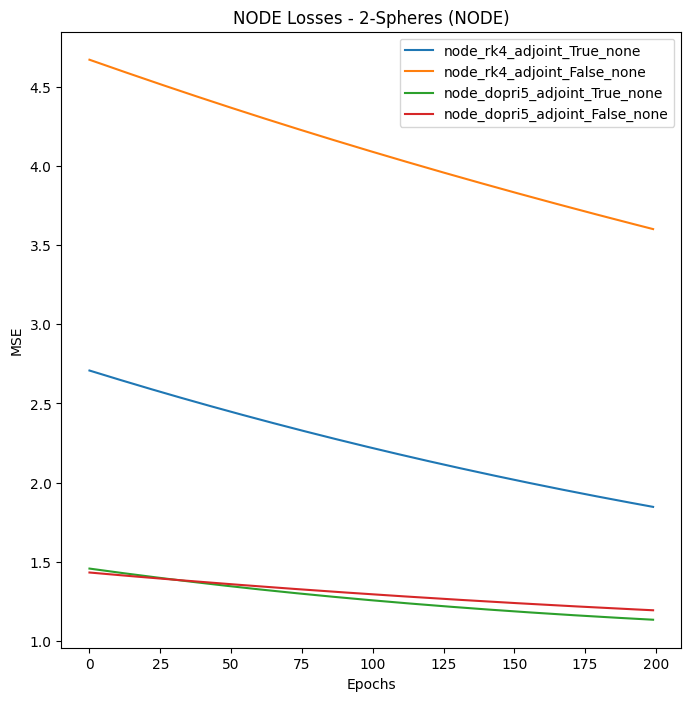

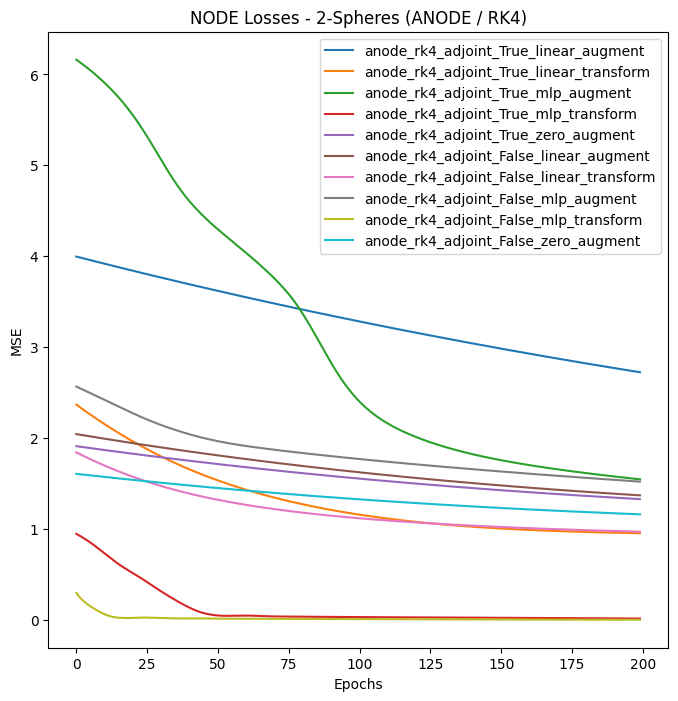

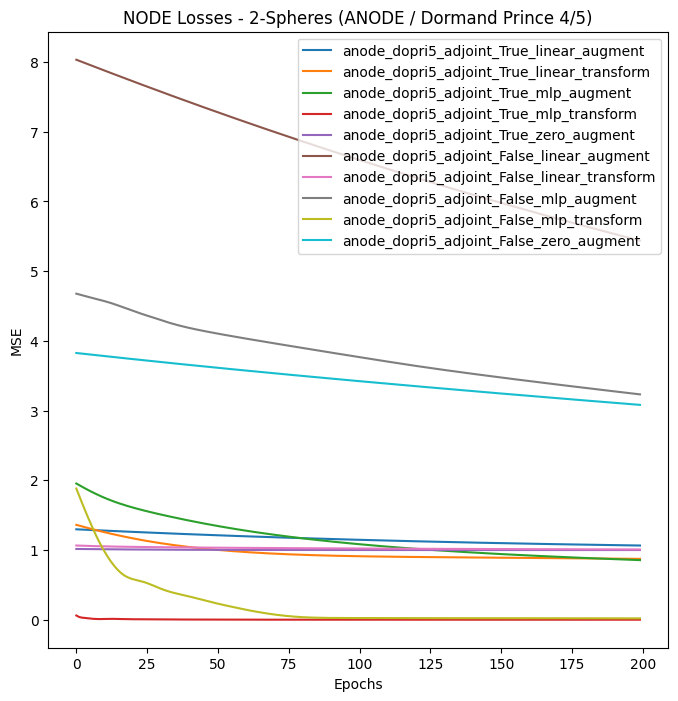

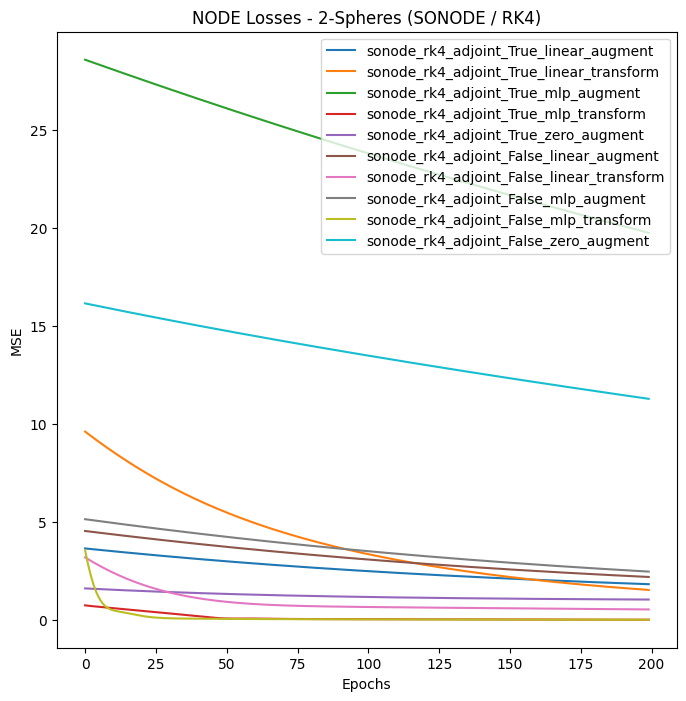

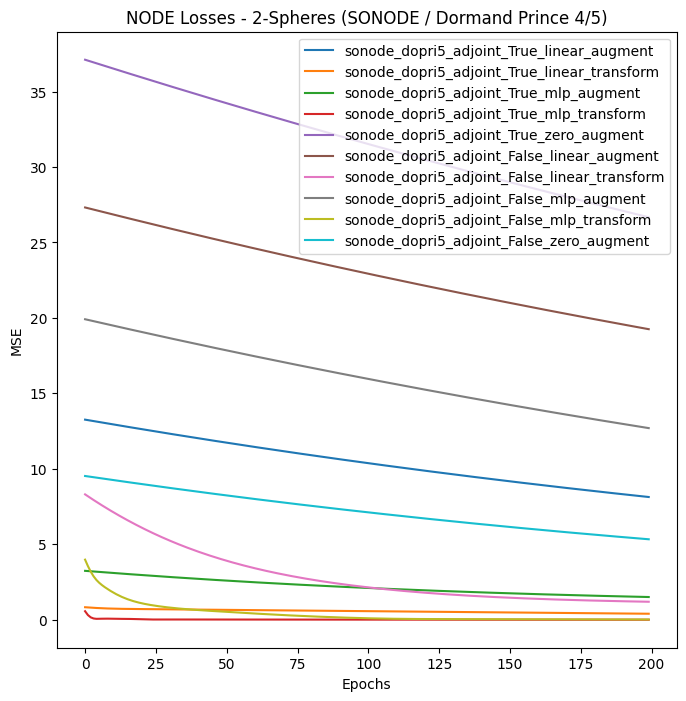

In [21]:
plot_results(query(model="node"), "NODE")
plot_results(query(model="anode", method="rk4"), "ANODE / RK4")
plot_results(query(model="anode", method="dopri5"), "ANODE / Dormand Prince 4/5")
plot_results(query(model="sonode", method="rk4"), "SONODE / RK4")
plot_results(query(model="sonode", method="dopri5"), "SONODE / Dormand Prince 4/5")

In [22]:
print("NaN'ed out:")
print(" -", "\n - ".join([exp.name for exp, result in zip(experiments, results) if np.isnan(result.losses[-1])]))

NaN'ed out:
 - 


Text(0.5, 1.0, 'NODE Training Time (s) - 2-Spheres')

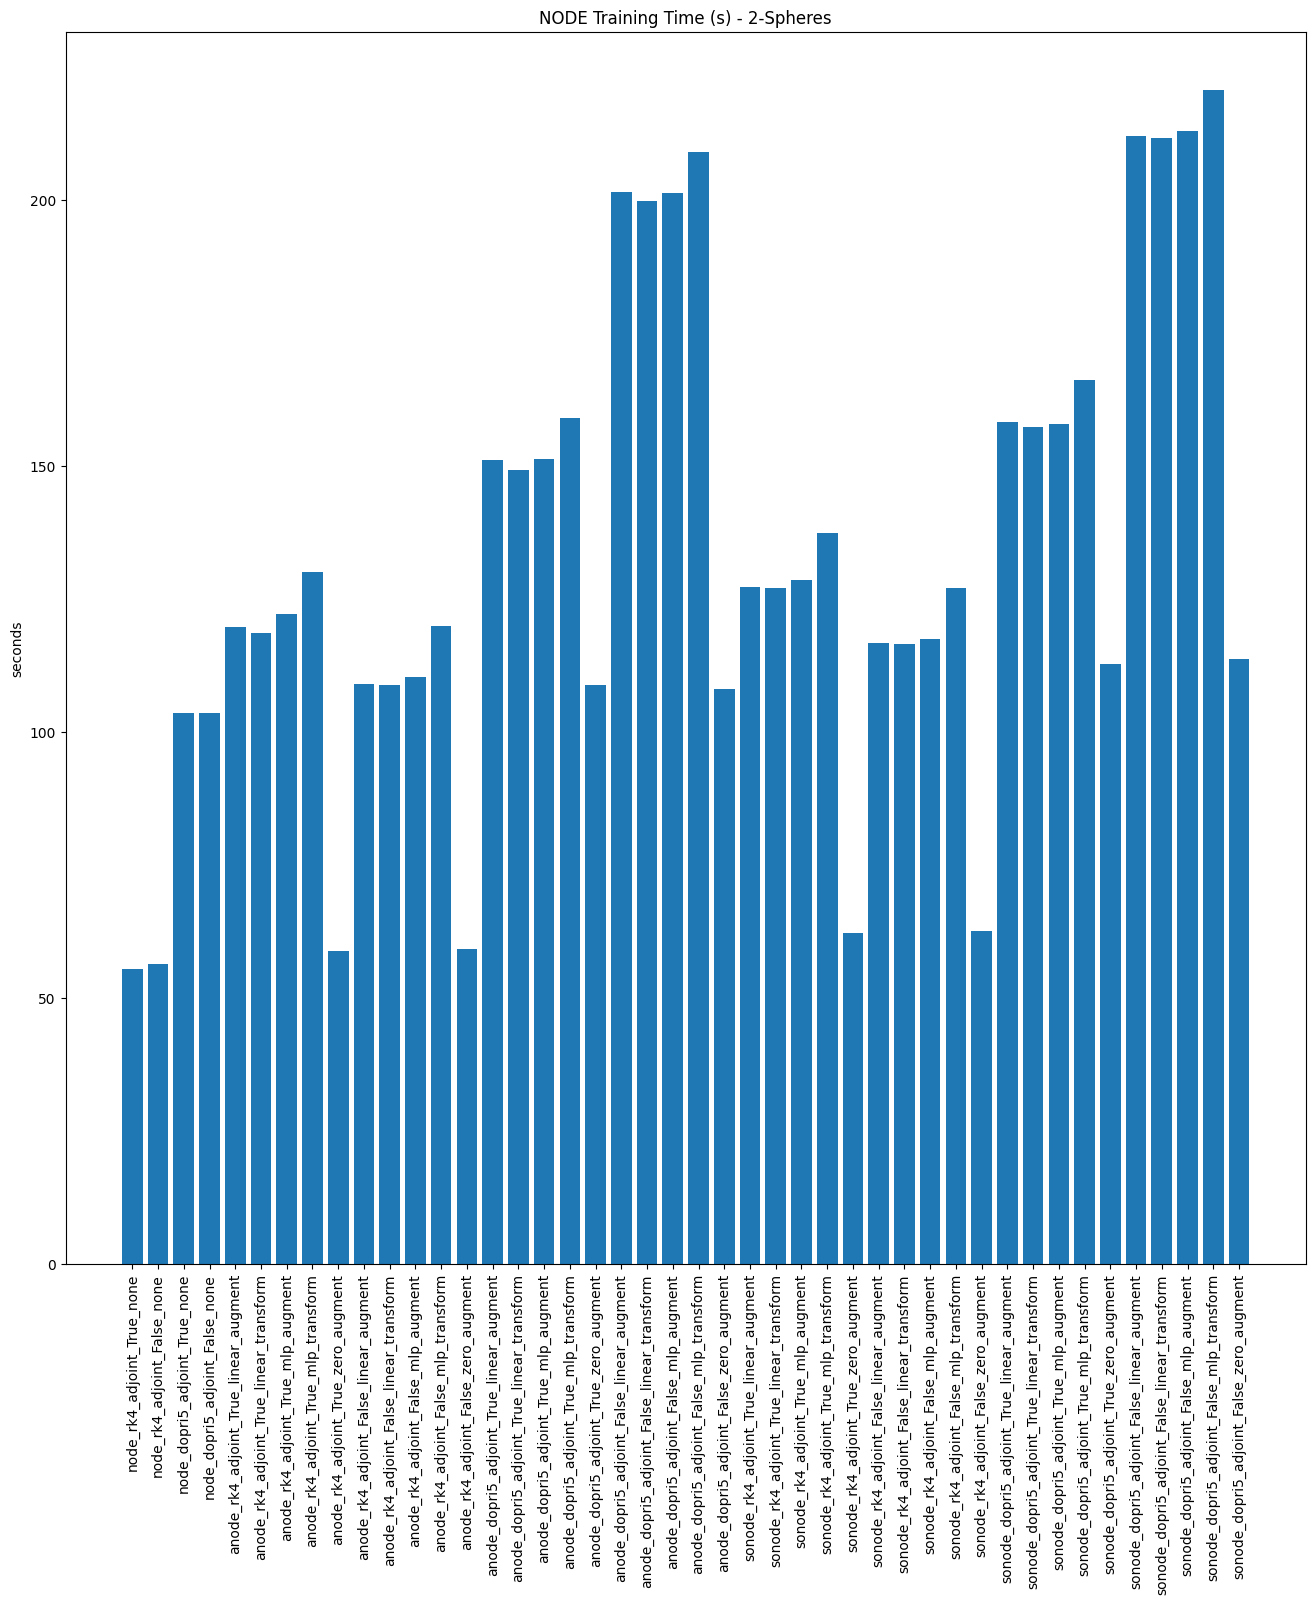

In [23]:
plot_results = [r for r in results if not np.isnan(r.losses[-1])]
plt.figure(figsize=(16,16))
plt.bar(np.arange(len(plot_results)), [r.duration_s for r in plot_results],
        tick_label=[r.name for r in plot_results])
plt.xticks(rotation = 90)
plt.ylabel("seconds")
plt.title("NODE Training Time (s) - 2-Spheres")